### in this notebook we check if we can find the "noisy" data with the metrics by shuffle 10% of the class of the data set and run sliding window of 40% fro the easiest to hardest example

In [1]:
import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.nn import functional
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from torchvision import transforms
from torchvision.datasets import ImageFolder

from train import ModelManager, Mode, DIR_ROOT_SAVE
from utils import plot_img_and_top, get_loader

DATA_PATH = os.path.join(os.path.abspath('./dataset'), 'veg2')
DATA_PATH_TRAIN = os.path.join(DATA_PATH, 'train')
DATA_PATH_VAL = os.path.join(DATA_PATH, 'validation')
DATA_PATH_TEST = os.path.join(DATA_PATH, 'test')
NOTEBOOK_NAME = 'veg2'
PATH_MEASURES = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'measure_veg2.pt')

# shuffle 10% of labels in the data:
### in this dataset there is 1000 train examples in each class, so we take 100 examples in each class and change thier class by remove the image to folder of other class

In [ ]:
i = 0
for dir_ in os.listdir(DATA_PATH_TRAIN):
    for file in os.listdir(os.path.join(DATA_PATH_TRAIN, dir_)):
        os.rename(os.path.join(os.path.join(DATA_PATH_TRAIN, dir_, file)),
                  os.path.join(os.path.join(DATA_PATH_TRAIN, dir_, f'{i}.jpg')))
        i += 1

dirs = os.listdir(DATA_PATH_TRAIN)
for dir_ in dirs:
    dir_path = os.path.join(DATA_PATH_TRAIN, dir_)
    files = os.listdir(dir_path)
    for i in random.sample(range(1000), 100):
        new_dir = dir_
        while new_dir == dir_:
            new_dir = dirs[random.randint(0, 14)]
        assert dir_ != new_dir
        assert not os.path.exists(os.path.join(DATA_PATH_TRAIN, new_dir, files[i]))
        shutil.move(os.path.join(dir_path, files[i]), os.path.join(DATA_PATH_TRAIN, new_dir, files[i]))

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_train = ImageFolder(DATA_PATH_TRAIN, transform=transform_train)
dataset_val = ImageFolder(DATA_PATH_VAL, transform=transform_test)
dataset_test = ImageFolder(DATA_PATH_TEST, transform=transform_test)
dataset_train_ordered = ImageFolder(DATA_PATH_TRAIN, transform=transform_test)
dataset_train_raw = ImageFolder(DATA_PATH_TRAIN)
dataset_test_raw = ImageFolder(DATA_PATH_TEST)

NUM_TRAIN = len(dataset_train)
TRAIN_IDX = np.arange(NUM_TRAIN)
NUM_VAL = len(dataset_val)
NUM_TEST = len(dataset_test)
CLASSES = dataset_train.classes
NUM_CLASSES = len(CLASSES)
PRUNE_EPOCHS = 10
ENSEMBLE_EPOCHS = 10
ENSEMBLE_SIZE = 10
BATCH_SIZE = 25
EPOCHS = 25

loader_train = get_loader(dataset_train, TRAIN_IDX, batch_size=BATCH_SIZE, shuffle=True)
loader_train_ordered = get_loader(dataset_train_ordered, TRAIN_IDX, batch_size=BATCH_SIZE, shuffle=False)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                        prefetch_factor=4, pin_memory=True, persistent_workers=True)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                         prefetch_factor=4, pin_memory=True, persistent_workers=True)

# check simple model's acc on the data

In [8]:
model_manager = ModelManager(num_classes=NUM_CLASSES, model_name='veg', load=False, dir_=NOTEBOOK_NAME,
                             simple_model=True)
model_manager.train(loader_train, loader_val, loader_test, 15)

Epoch: 0 Train: Loss: 0.083859 Acc: 0.370600  Validate Loss: 0.063920 Acc: 0.562667                                                         
Validation loss decreased (inf --> 0.063920).  Saving model to models_data/veg2\veg
Epoch: 1 Train: Loss: 0.070311 Acc: 0.507333  Validate Loss: 0.056643 Acc: 0.605333                                                         
Validation loss decreased (0.063920 --> 0.056643).  Saving model to models_data/veg2\veg
Epoch: 2 Train: Loss: 0.065313 Acc: 0.547400  Validate Loss: 0.051400 Acc: 0.623333                                                         
Validation loss decreased (0.056643 --> 0.051400).  Saving model to models_data/veg2\veg
Epoch: 3 Train: Loss: 0.062094 Acc: 0.586133  Validate Loss: 0.048474 Acc: 0.660333                                                         
Validation loss decreased (0.051400 --> 0.048474).  Saving model to models_data/veg2\veg
Epoch: 4 Train: Loss: 0.059703 Acc: 0.606667  Validate Loss: 0.045145 Acc: 0.675000  

# Confusion Matrix

In [40]:
model_manager.model.cuda()
scores, pred, loss, acc = model_manager.run_epoch(loader_test, Mode.TEST)
ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)(pred.cpu(), Tensor(dataset_test.targets)).numpy()

array([[187,   1,   0,   2,   2,   0,   0,   0,   3,   2,   0,   2,   1,
          0,   0],
       [  1, 188,   0,   0,   2,   0,   0,   0,   0,   0,   2,   0,   1,
          6,   0],
       [  0,   0, 199,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0, 191,   1,   1,   0,   0,   0,   1,   6,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 178,   0,   0,   0,   0,   0,  14,   7,   0,
          0,   1],
       [  0,   0,   0,   0,   2, 189,   0,   0,   3,   0,   3,   0,   3,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 145,   0,   0,   0,   2,  53,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  54,   0,   0,  88,  58,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0, 194,   0,   1,   3,   1,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 200,   0,   0,
       

In [11]:
def get_el2n_scores(y: Tensor, ensemble_softmax_: Tensor):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_softmax_: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_softmax_.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_softmax_, ord=2, dim=2), dim=0)

# Train ensemble of 10 simple models and extract measures: EL2N, STD and pred sum

In [12]:
ensemble: list[ModelManager] = [
    ModelManager(NUM_CLASSES, model_name=f'ensemble_{i}', dir_=NOTEBOOK_NAME, load=False, simple_model=True)
    for i in range(ENSEMBLE_SIZE)
]

ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)
Y_train = Tensor(dataset_train.targets).type(torch.int64)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, ENSEMBLE_EPOCHS)
    model_manager.model.cuda()
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    scores, pred = scores.cpu(), pred.cpu()
    ensemble_softmax[i] = functional.softmax(scores, dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int64) == Y_train)  #.clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_std = ensemble_softmax.std(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)

measures = {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred,
            'ensemble_pred_sum': ensemble_pred_sum,
            'ensemble_std': ensemble_std, 'el2n_scores': el2n_scores}


------------   model 0   -------------------
Epoch: 0 Train: Loss: 0.079428 Acc: 0.415533  Validate Loss: 0.058015 Acc: 0.587000                                                         
Validation loss decreased (inf --> 0.058015).  Saving model to models_data/veg2\ensemble_0
Epoch: 1 Train: Loss: 0.066045 Acc: 0.557333  Validate Loss: 0.050048 Acc: 0.639333                                                         
Validation loss decreased (0.058015 --> 0.050048).  Saving model to models_data/veg2\ensemble_0
Epoch: 2 Train: Loss: 0.061653 Acc: 0.595200  Validate Loss: 0.046890 Acc: 0.669000                                                         
Validation loss decreased (0.050048 --> 0.046890).  Saving model to models_data/veg2\ensemble_0
Epoch: 3 Train: Loss: 0.059003 Acc: 0.621600  Validate Loss: 0.043036 Acc: 0.719667                                                         
Validation loss decreased (0.046890 --> 0.043036).  Saving model to models_data/veg2\ensemble_0
Epoch: 4 Tr

# Train simple models 10 epochs and extract measures: flip and forget

In [13]:
epochs_pred = torch.empty((PRUNE_EPOCHS, NUM_TRAIN), dtype=torch.int8)
flip = torch.zeros(NUM_TRAIN, dtype=torch.int8)
train_res = None

model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=False, simple_model=True)
loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
model_manager.model.to(ModelManager.DEVICE)

for epoch in range(PRUNE_EPOCHS):
    model_manager.model.to(ModelManager.DEVICE)
    train_res = model_manager.run_epoch(loader_train, Mode.TRAIN)
    valid_res = model_manager.run_epoch(loader_test, Mode.VALIDATE)
    loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
    acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
    s = f'Epoch: {epoch} Train: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  ' \
        f'Validate Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  '

    train_res = model_manager.run_epoch(loader_train_ordered, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        changes_mean = changes.type(torch.float64).mean()
        model_manager.tb.add_scalar('changes_mean', changes_mean, epoch)
        flip += changes
        s += f'Changes {changes_mean:.2%}'

    print(s), model_manager.model.cpu()
    model_manager.epochs += 1

model_manager.save_model()
model_manager.data['train']['loss'] += loss_train
model_manager.data['train']['acc'] += acc_train
model_manager.data['valid']['loss'] += loss_valid
model_manager.data['valid']['acc'] += acc_valid

model_manager.save_data(data_other={'last_scores': train_res[0]})

# extract forget scores
epochs_pred_bool = epochs_pred == Y_train
forget = torch.zeros(NUM_TRAIN, dtype=torch.int8)
for i in range(1, PRUNE_EPOCHS):
    forget += (epochs_pred_bool[i - 1] & (~epochs_pred_bool[i]))

measures = {**measures, **{'epochs_pred': epochs_pred, 'flip': flip, 'forget': forget}}
torch.save(measures, PATH_MEASURES)

Epoch: 0 Train: Loss: 0.083341 Acc: 0.380267  Validate Loss: 0.062967 Acc: 0.520333                                                         
Epoch: 1 Train: Loss: 0.068757 Acc: 0.521067  Validate Loss: 0.054394 Acc: 0.605333  Changes 31.50%                                         
Epoch: 2 Train: Loss: 0.063784 Acc: 0.567067  Validate Loss: 0.048868 Acc: 0.646000  Changes 22.98%                                         
Epoch: 3 Train: Loss: 0.060432 Acc: 0.593133  Validate Loss: 0.047172 Acc: 0.650000  Changes 20.69%                                         
Epoch: 4 Train: Loss: 0.058420 Acc: 0.612800  Validate Loss: 0.044036 Acc: 0.691333  Changes 19.38%                                         
Epoch: 5 Train: Loss: 0.056835 Acc: 0.630000  Validate Loss: 0.041932 Acc: 0.700333  Changes 19.91%                                         
Epoch: 6 Train: Loss: 0.055593 Acc: 0.638933  Validate Loss: 0.039863 Acc: 0.717333  Changes 20.46%                                         
Epoch: 7 Trai

# load mesures from the file demonstrate the distribution of the measures on the dataset and the correlation between measures

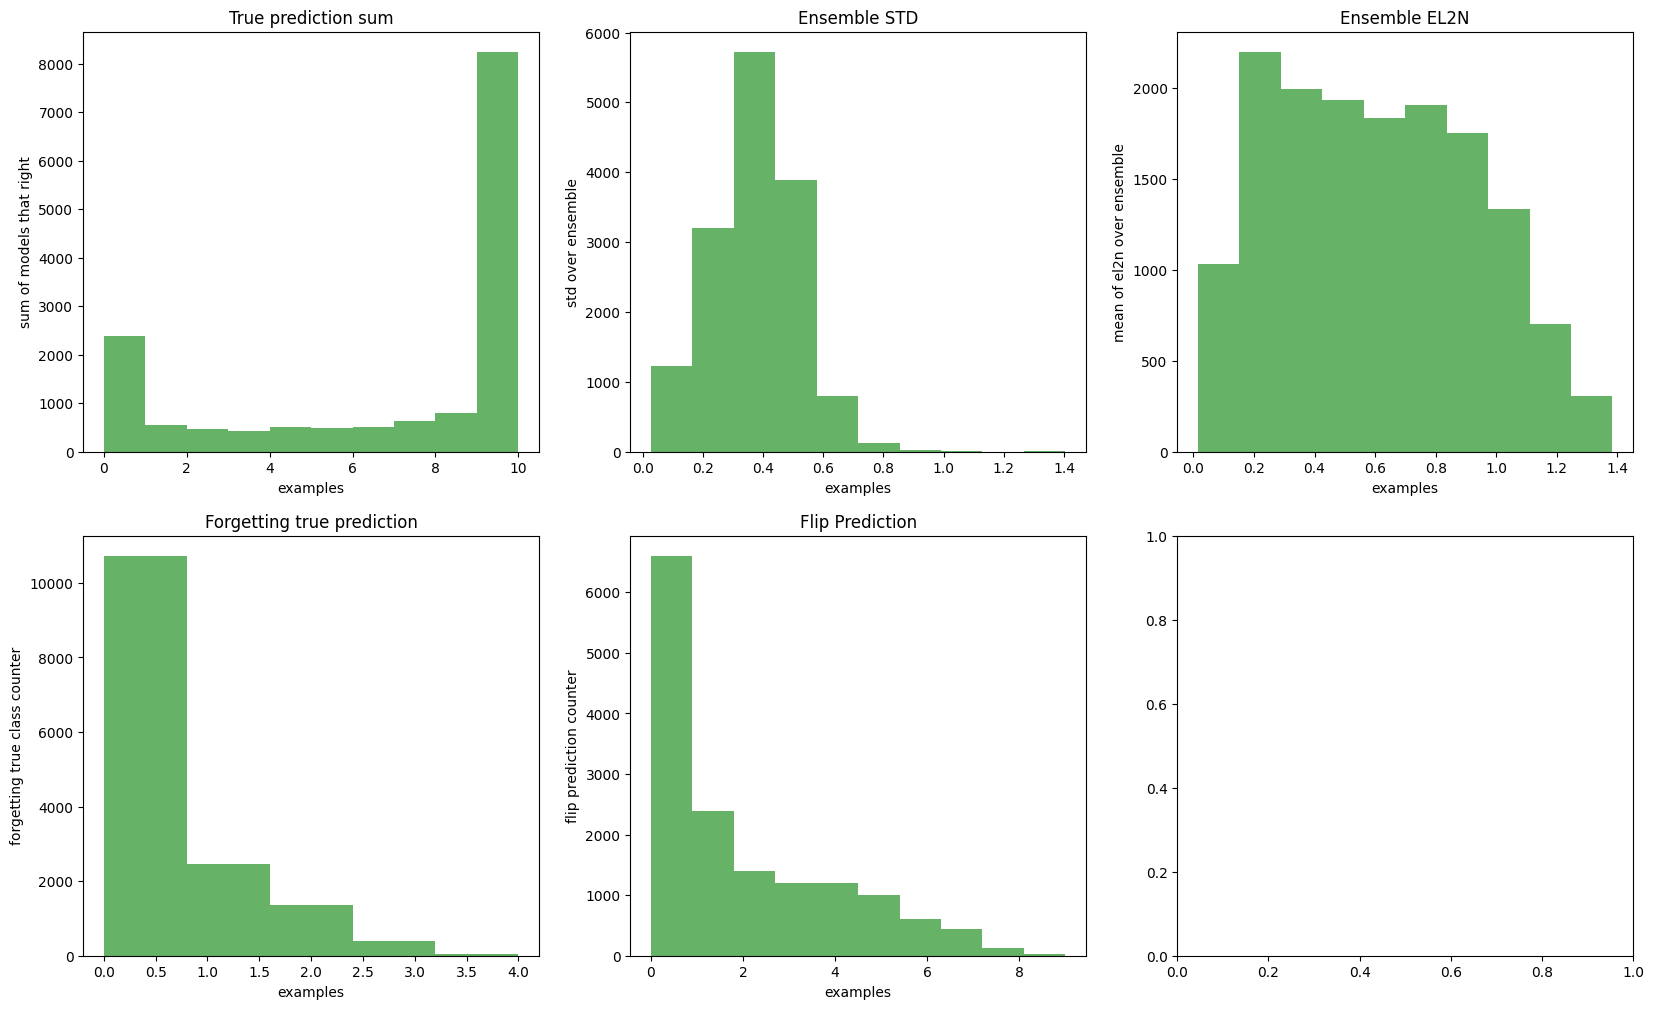

,EL2N,Std,True p sum,flip,forget
EL2N,1.000000,0.584944,-0.900481,0.447177,0.188134
Std,0.584944,1.000000,-0.446224,0.467473,0.243629
True p sum,-0.900481,-0.446224,1.000000,-0.378129,-0.080537
flip,0.447177,0.467473,-0.378129,1.000000,0.711084
forget,0.188134,0.243629,-0.080537,0.711084,1.000000


In [4]:
measures = torch.load(PATH_MEASURES)

pred_sum = measures['ensemble_pred_sum']
std = measures['ensemble_std'].sum(dim=1)
el2n = measures['el2n_scores']
forget = measures['forget']
flip = measures['flip']

idx_sorted_el2n = el2n.sort()[1].numpy()
idx_sorted_flip = flip.sort()[1].numpy()
idx_sorted_std = std.sort()[1].numpy()
idx_sorted_pred_sum = pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_flip, 'forget': idx_true_forget}

for ax, measure, title, y_label in zip(
        plt.subplots(2, 3, figsize=(20, 12))[1].reshape(-1),
        [pred_sum, std, el2n, forget, flip],
        ['True prediction sum', 'Ensemble STD', 'Ensemble EL2N', 'Forgetting true prediction', 'Flip Prediction'],
        ['sum of models that right', 'std over ensemble', 'mean of el2n over ensemble', 'forgetting true class counter',
         'flip prediction counter']):
    ax.set_ylabel(y_label)
    ax.set_xlabel('examples')
    ax.set_title(title)
    ax.hist(measure, bins=10 if title != 'Forgetting true prediction' else 5, facecolor='g', alpha=0.6)
plt.show()

data = pd.DataFrame({
    'EL2N': el2n.numpy(),
    'Std': std.numpy(),
    'True p sum': pred_sum.numpy(),
    'flip': flip.numpy(),
    'forget': forget.numpy()
})
data.corr()

# hardest examples according to forget

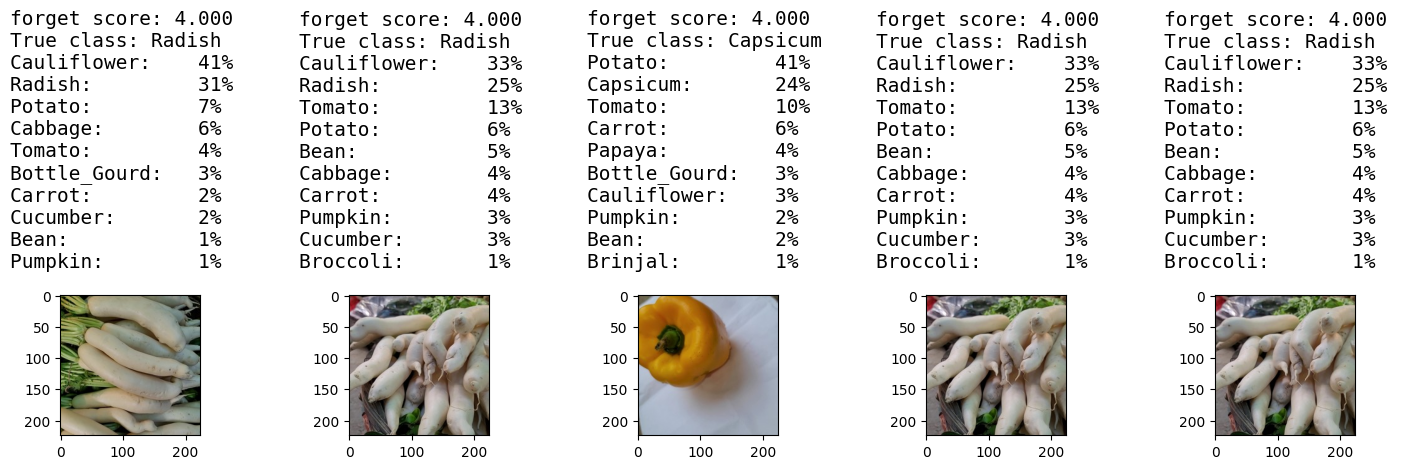

In [15]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.999, 1.), forget,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='forget')

# hardest examples according to pred sum

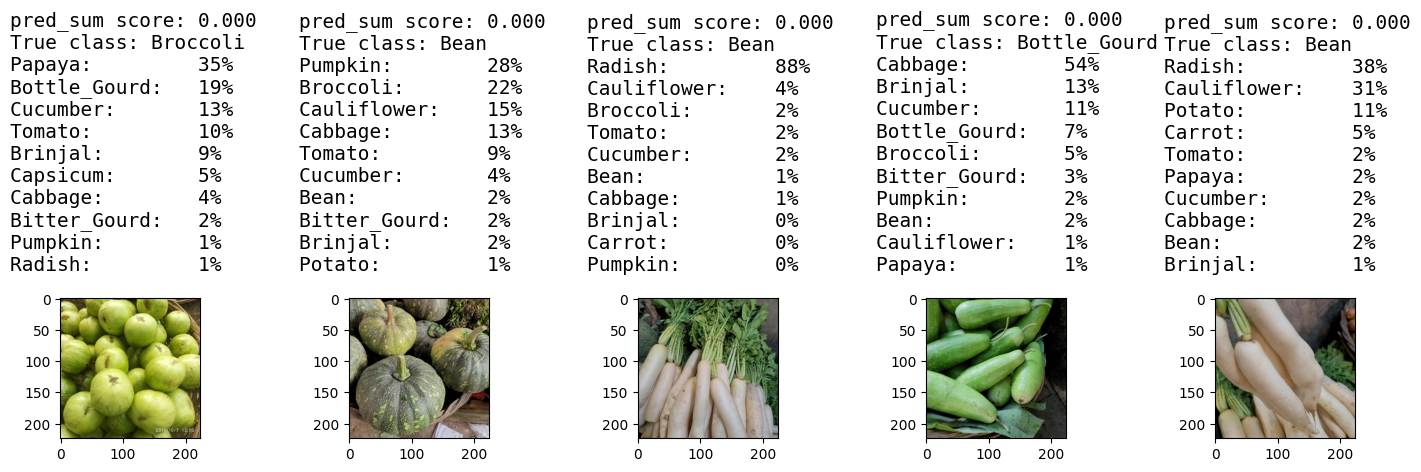

In [30]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.0, .02), pred_sum,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1), score_name='pred_sum')

# hardest examples according to el2n

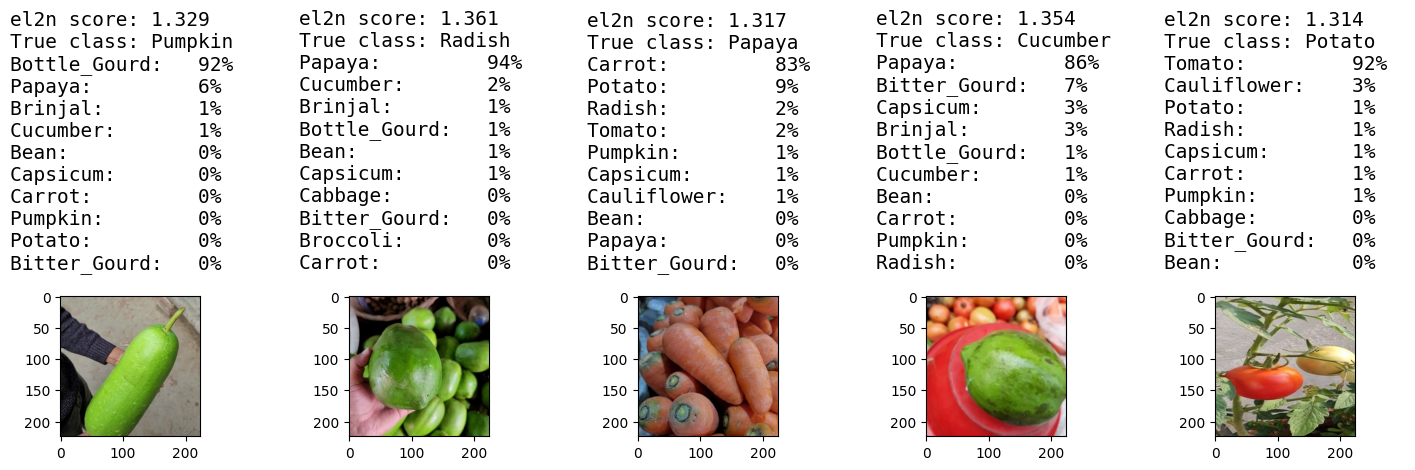

In [26]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.99, 1.), el2n,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='el2n')

# hardest examples according to flip

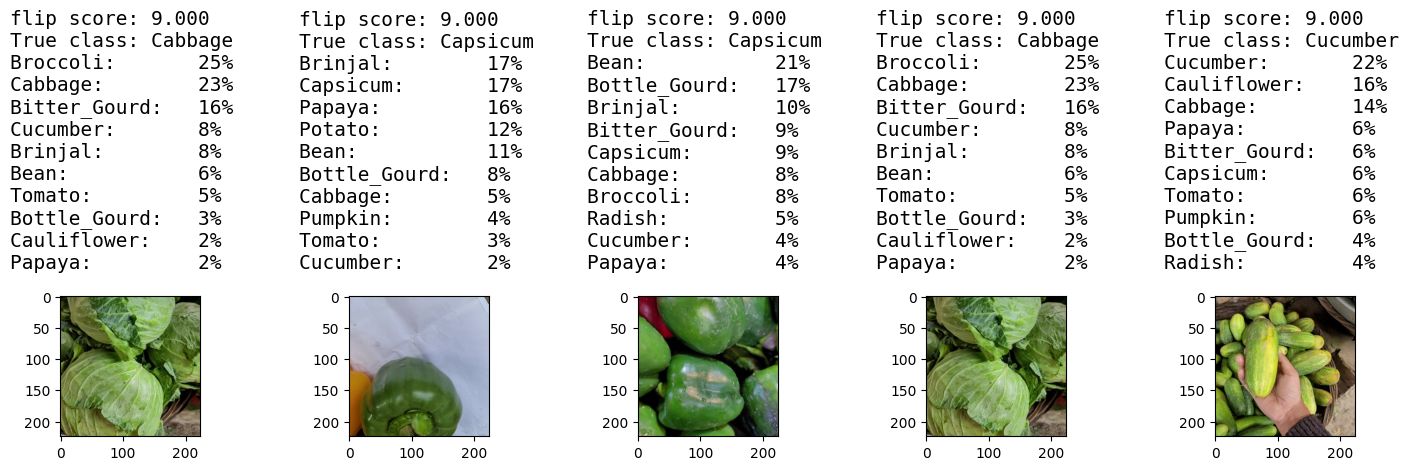

In [18]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.999, 1.), flip,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='flip')

# hardest examples according to std

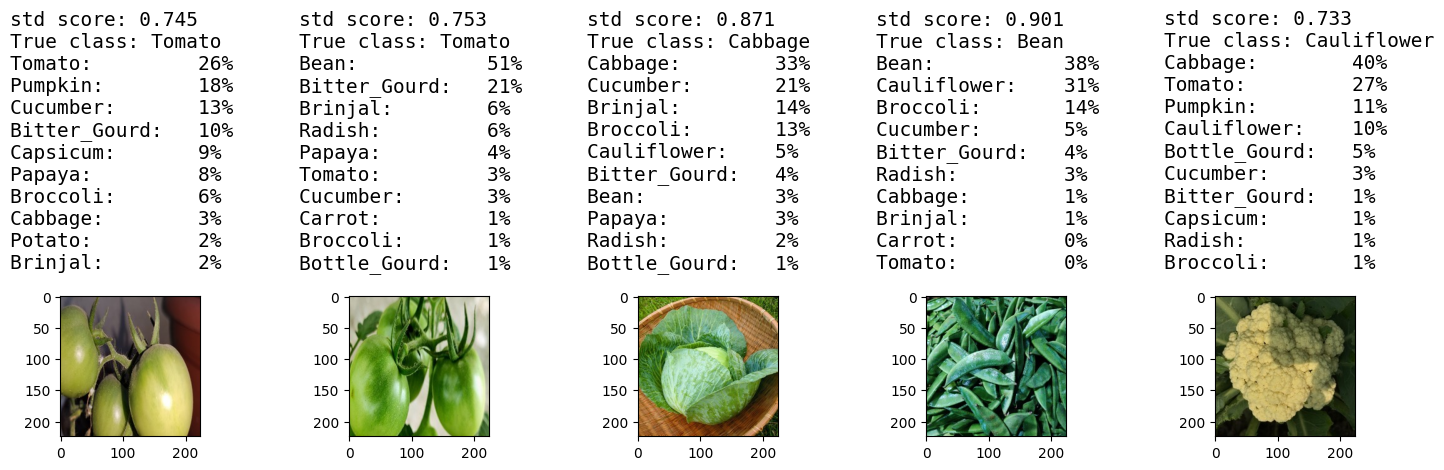

In [7]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.99, 1.), std,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='std')

# Experiment 2.2
### train resnet18 on pruned dataset according to each measure, the prune is sliding window of 40% of examples from the easiest to hardest

In [37]:
exp2_prune = int(NUM_TRAIN * .4)
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=False)
loader_train = get_loader(dataset_train, TRAIN_IDX, BATCH_SIZE, True)
no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

# random
model_random = ModelManager(NUM_CLASSES, model_name='exp2_random', dir_=NOTEBOOK_NAME, load=False)
loader_train = get_loader(dataset_train, idx_random_prune[:exp2_prune], BATCH_SIZE, True)
model_random.train(loader_train, loader_test, loader_test, EPOCHS)

start_points = [.0, .1, .2, .3, .4, .5, .51, .52, .53, .54, .55, .56, .57, .58, .59, .6]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in start_points},
                                         'random': {p: model_random.data['test']['acc'] for p in start_points}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for start_point in start_points:
        start = round(NUM_TRAIN * start_point)
        print(f'====     train model from {start} to {start + exp2_prune} with {name} method    ======')
        loader_train = get_loader(dataset_train, idx[start:start + exp2_prune], BATCH_SIZE, True)
        model_manager = ModelManager(NUM_CLASSES, model_name=f'exp_2{name}_{int(start_point * 100)}',
                                     dir_=NOTEBOOK_NAME, load=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

        acc_test[name][start_point] = model_manager.data['test']['acc']
        print()

Epoch: 0 Train: Loss: 0.061947 Acc: 0.562333  Validate Loss: 0.028992 Acc: 0.803333                                                         
Validation loss decreased (inf --> 0.028992).  Saving model to models_data/veg2\exp2_random
Epoch: 1 Train: Loss: 0.044311 Acc: 0.727667  Validate Loss: 0.021883 Acc: 0.823333                                                         
Validation loss decreased (0.028992 --> 0.021883).  Saving model to models_data/veg2\exp2_random
Epoch: 2 Train: Loss: 0.038570 Acc: 0.780167  Validate Loss: 0.032842 Acc: 0.749000                                                         
Epoch: 3 Train: Loss: 0.035412 Acc: 0.806833  Validate Loss: 0.014421 Acc: 0.914000                                                         
Validation loss decreased (0.021883 --> 0.014421).  Saving model to models_data/veg2\exp2_random
Epoch: 4 Train: Loss: 0.033663 Acc: 0.825167  Validate Loss: 0.015620 Acc: 0.891000                                                         
Epoch: 5 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017316459BD0>
Traceback (most recent call last):
  File "C:\Users\ProjectUser\temp\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "C:\Users\ProjectUser\temp\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1425, in _shutdown_workers
    self._mark_worker_as_unavailable(worker_id, shutdown=True)
  File "C:\Users\ProjectUser\temp\venv\lib\site-packages\torch\utils\data\dataloader.py", line 1367, in _mark_worker_as_unavailable
    assert self._workers_status[worker_id] or (self._persistent_workers and shutdown)
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Epoch: 6 Train: Loss: 0.027372 Acc: 0.851500  Validate Loss: 0.025602 Acc: 0.791333                                                         
Epoch: 7 Train: Loss: 0.026535 Acc: 0.855167  Validate Loss: 0.026825 Acc: 0.824667                                                         
Epoch: 8 Train: Loss: 0.025943 Acc: 0.863833  Validate Loss: 0.018858 Acc: 0.862000                                                         
Validation loss decreased (0.018888 --> 0.018858).  Saving model to models_data/veg2\exp_2el2n_53
Epoch: 9 Train: Loss: 0.024382 Acc: 0.873833  Validate Loss: 0.011481 Acc: 0.919000                                                          
Validation loss decreased (0.018858 --> 0.011481).  Saving model to models_data/veg2\exp_2el2n_53
Epoch: 10 Train: Loss: 0.024102 Acc: 0.872833  Validate Loss: 0.018211 Acc: 0.888667                                                          
Epoch: 11 Train: Loss: 0.023407 Acc: 0.876333  Validate Loss: 0.012962 Acc: 0.923333            

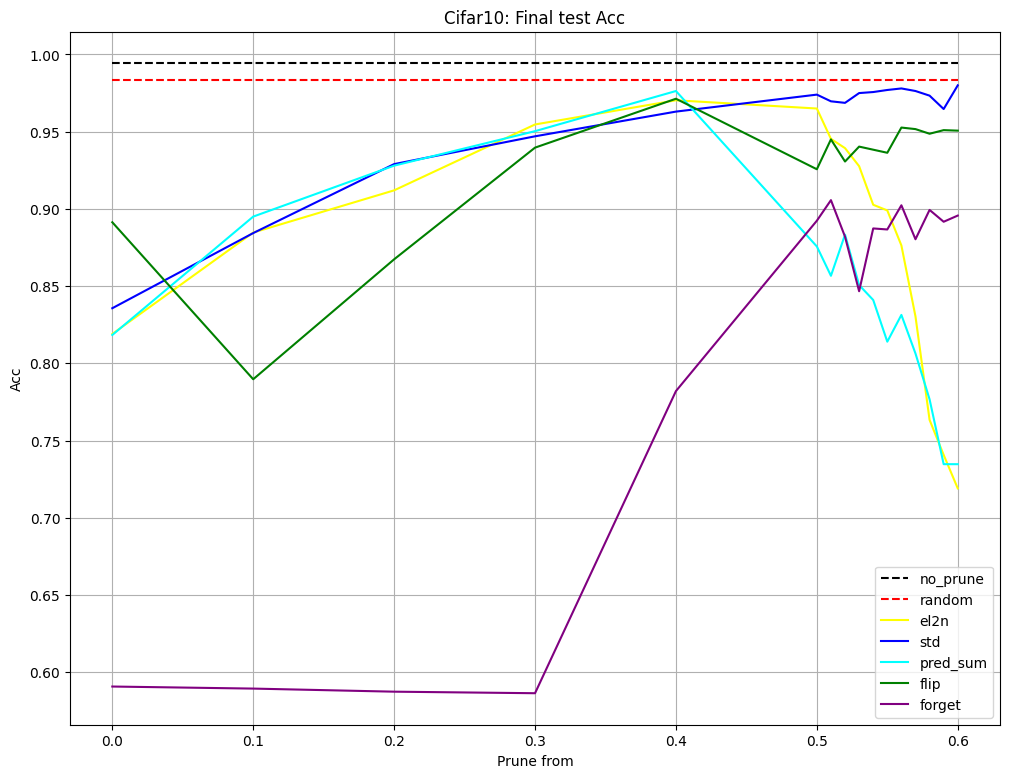

In [39]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget

markers = ('dashed', 'solid')
for i, prune_method in enumerate(acc_test):
    plt.plot(start_points, [acc_test[prune_method][p] for p in start_points], label=prune_method, c=colors[i],
             linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune from')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()